# Analysis of Health Inspections Across Prince George's County

In this notebook, we will be analysing the data of health inspections of various establishments across PG County. 
We will be basing the analysis on specific questions related to processing and plotting the data.
For this analysis, numpy, pandas, datetime, and re libraries are used for data manipulation while matplotlib and seaborn libraries are used for visualizations.

In [63]:
#Import the libraries that support the functionalities we require for analysis 
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.graph_objects as go

## Getting the data

Let's first load the data into a friendly neighborhood pandas dataframe. 

In [64]:
# Extracting the dataset into a pandas dataframe

df = pd.read_csv(r'Food Inspection.csv')

Let's examine the variables and their types in the dateset.

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34736 entries, 0 to 34735
Data columns (total 30 columns):
Establishment_id                       34736 non-null int64
Name                                   34736 non-null object
Category                               34068 non-null object
Inspection_date                        34736 non-null object
Inspection_results                     34736 non-null object
City                                   34715 non-null object
State                                  34736 non-null object
Zip                                    34733 non-null float64
Address_line_1                         34733 non-null object
Address_line_2                         34736 non-null object
Food_from_approved_source              34736 non-null object
Food_protected_from_contamination      34736 non-null object
Ill_workers_restricted                 34736 non-null object
Proper_hand_washing                    34736 non-null object
Cooling_time_and_temperature         

## Date Preparation and Cleaning

### Closer look at Categories

<b>Question</b>: Create a table of the unique values of Category. Which values do you believe represent a restaurant? Explain which categories you chose in a markdown cell. Create a single dummy variable for restaurant that combines multiple values from Category.

In [66]:
cat_df = pd.DataFrame(df['Category'].unique())
# cat_df

The dictionary definition for a restaurant is -
<i><b>a place where people pay to sit and eat meals that are cooked and served on the premises</b></i>. 

I believe that the categories that reasonably fit this definition are -
 
- 'Fast Food'  
- 'Hotel' 
- 'Full Service' 
- 'Ice Cream'
- 'Bakery/Catering' 
- 'Restaurant' 
- 'Bar/Tavern/Lounge'
- 'Limited Service' 
- 'Casino'
- 'Bakery' 
- 'Coffee Shop'
- 'Cafeteria' 
- 'Deli' 
- 'Private Club'
- 'Fast Food - Chain' 
- 'Full Service/Catering' 
- 'Buffet'
- 'Pizza'
- 'Fast Food - Local'
- 'Night Club' 
- '@Full Service' 
- 'Diner' 

Now, we can create a dummy variable which is 1 if the establishment has a restaurant setting/service and 0 otherwise.

In [67]:
restaurant_cat = ['Fast Food', 'Hotel', 'Full Service', 
'Ice Cream', 'Bakery/Catering', 'Restaurant', 
'Bar/Tavern/Lounge', 'Limited Service', 'Casino', 
'Bakery', 'Coffee Shop', 'Cafeteria', 
'Deli', 'Private Club', 'Fast Food - Chain', 
'Full Service/Catering', 'Buffet', 'Pizza',
'Fast Food - Local', 'Night Club', '@Full Service', 'Diner' ]

df['IsRestaurant'] = np.where(df['Category'].isin(restaurant_cat), 1, 0)

### Inspection_date

<b>Question</b>: Convert the Inspection_date column into a datetime column. Create a new column for the year of the inspection. Create a new column for the month of the inspection. Create a column for the year and month.

In [68]:
# Converting Inspection_date to datetime
df['Inspection_date'] = pd.to_datetime(df['Inspection_date'])

In [69]:
# Creating new columns extracting year and month from Inspection_date
df['Inspection_year'] = df['Inspection_date'].dt.year
df['Inspection_month'] = df['Inspection_date'].dt.month
# Create a column combining year and month
df['Month_Year'] = df['Inspection_month'].astype(str) + ', ' + df['Inspection_year'].astype(str) 

### Type of Compliance

<b>Question</b>: For each column with the type of compliance, e.g. "Rodent and Insects," create a dummy variable that is 1 if the establishment is out of compliance and 0 otherwise. Use np.nan for not applicable. Drop the string columns (retain only the dummy variables).

In [70]:
# Getting all the columns with compliance data
# df.iloc[:, 10:25].head()

In [71]:
for col in df.iloc[:, 10:25].columns:
    df[col] = np.where(df[col] == 'In Compliance', 0,
                           np.where(df[col] == 'Out of Compliance',1, np.nan))

In [72]:
# Take a look at the transformed df
# df.iloc[:, 10:25].head()

### Number of Violations

<b>Question</b>: Create a new column that contains the number of violations for that inspection (the number of categories where the establishment was not in compliance). Create a dummy variable that is 1 if the establishment is out of compliance in any category.

In [73]:
# Creating a new column to record total number of violations
df['No_of_Violations'] = df.iloc[:, 10:25].sum(axis = 1)

In [74]:
# Creating a new column to record if establishment is out of compliance in at least one category
df['Out_of_Compliance'] = np.where(df['No_of_Violations'] >= 1, 1, 0)

In [75]:
# Take a look at the new columns and verify
df[['No_of_Violations', 'Out_of_Compliance']].head()

,No_of_Violations,Out_of_Compliance
0,1.0,1
1,1.0,1
2,0.0,0
3,0.0,0
4,2.0,1


### Establishments with Multiple Inspections

<b>Question</b>: For establishments with multiple inspections, create a new DataFrame in wide format. Keep only the establishment ID, Category, Inspection_date, and number of violations. Make sure category is consistent within ID and resolve any discrepancies if necessary (i.e. each establishment has only one category). Reshape from long to wide (pivot) such that each establishment is a row and you have a column for the date and number of violations for inspection 1, inspection 2, inspection 3, etc.

For this, let's see if every establishment has a unique category.

In [76]:
# Checking unique counts for the category column with respect to each establishment
df[['Establishment_id', 'Category']].groupby('Establishment_id').nunique().head()

,Establishment_id,Category
Establishment_id,,
1,1,1
2,1,2
3,1,1
4,1,2
5,1,1


Looks like the data does have discrepancies in the category column. We need to fix this before creating a wide dataframe. We do this by first creating a dictionary that has Establishment_ids as the keys and the first value from the corresponding list of unique categories. For convenience sake, we are choosing the first value although there can be more advanced methods to find the most popular category for each establishment and assigning that value to all rows with that establishment.  

In [77]:
# Create a dictionary with Establishment_id as key and first value of unique category list as value
new_dict = df.groupby('Establishment_id')['Category'].apply(lambda x: x.unique().tolist()[0]).to_dict()

# To preserve data in the original Category column, we shall create a new column called Category_New with corrected categories from new_dict
df['Category_New'] = df["Establishment_id"].map(new_dict) 

Now we can find out if this has worked.

In [78]:
df[['Establishment_id', 'Category_New']].groupby('Establishment_id').nunique().head()

,Establishment_id,Category_New
Establishment_id,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


It worked! Now moving on..

For creating the new wide dataframe, let's make a column called 'Inspection_No' for keeping a cumulative count of the number of inspections for each establishment. For this, we sort the dataframe by the inspection date so that the 1st inspection for an establishment corresponds to the earliest date and so on.

Next, we shall use set_index(), stack(), and unstack() such that data is arranged by unique establishment_id in each row and the data of Inspection_date and No_of_Violations is in columns and arrange the columns by Inspection_No.

Note: We will be using the Category_New column instead of Category for it is the one with consistency.

In [79]:
df['Inspection_No'] = df.sort_values('Inspection_date').groupby(['Establishment_id']).cumcount()+1
cols = ['Establishment_id', 'Category_New', 'Inspection_date', 'No_of_Violations', 'Inspection_No']

df1 = df[cols].sort_values(['Establishment_id','Inspection_No']).set_index(['Establishment_id','Category_New','Inspection_No']).stack().unstack([2,3])
# df1.head()

## Statistics/Data Grouping

### Common Types of Violations

<b>Question</b>: What is the most common type of violation? The compliance categories are not mutually exclusive because one restaurant can have multiple violations. Create a table with the number of violations by violation type. Sort the table from the most common to least common violations.

In [80]:
vdf = pd.DataFrame(np.sum(df.iloc[:,10:25], axis=0), columns=['Frequency']).reset_index().sort_values('Frequency', ascending = False)
vdf

,index,Frequency
5,Cold_holding_temperature,6725.0
14,Food_contact_surfaces_and_equipment,6044.0
13,Rodent_and_insects,5816.0
6,Hot_holding_temperature,3435.0
1,Food_protected_from_contamination,1368.0
3,Proper_hand_washing,1248.0
4,Cooling_time_and_temperature,338.0
9,Hot_and_cold_running_water_provided,229.0
7,Cooking_time_and_temperature,157.0
8,Reheating_time_and_temperature,138.0


### Pivot, Pivot, Pivot

<b>Question</b>: For establishments with multiple inspections, how many reinspections does it take for an establishment to become compliant? Create a table where each row is the number of inspections a restaurant has had and the columns are the number of reinspections until the establishment becomes compliant. 

In [81]:
# First, we create a dataframe with data of Establishment_id, number of inspections, and corresponding inspection results
jdf = df[['Establishment_id', 'Inspection_date', 'Inspection_date', 'Inspection_No', 'Inspection_results']].sort_values(['Establishment_id', 'Inspection_No'], ascending=[True, False])

In [82]:
# Let's find out the unique values in Inspection_results column
jdf['Inspection_results'].unique()

array(['Non-Compliant - Violations Observed',
       'Critical Violations observed', '------',
       'Compliant - No Health Risk', 'Facility Reopened',
       'Facility Closed', 'Compliance Schedule - Completed',
       'Compliance Schedule - Outstanding', 'Compliant - Health Risk',
       'No Critical Violations Observed'], dtype=object)

In [83]:
compliant_cat = ['Compliant - No Health Risk', 'Facility Reopened', 
                 'Compliance Schedule - Completed', 
                 'Compliance Schedule - Outstanding', 
                 'Compliant - Health Risk',
                 'No Critical Violations Observed']
jdf['Compliant'] = np.where(jdf['Inspection_results'].isin(compliant_cat), 1, 0)

In [84]:
# jdf.head(30)

The data shows that there are mutliple instances where establishments have been alternating between compliant on non-compliant across multiple inspections which shows that maybe there seem to be violations cropping up seasonally/and or inconsistency in maintenance of the establishment.

## Data Visualization

### Violation Frequencies on a Plot

<b>Question</b>: Create a bar graph showing the frequency of each violation.

Text(0,0.5,'Type of Violation')

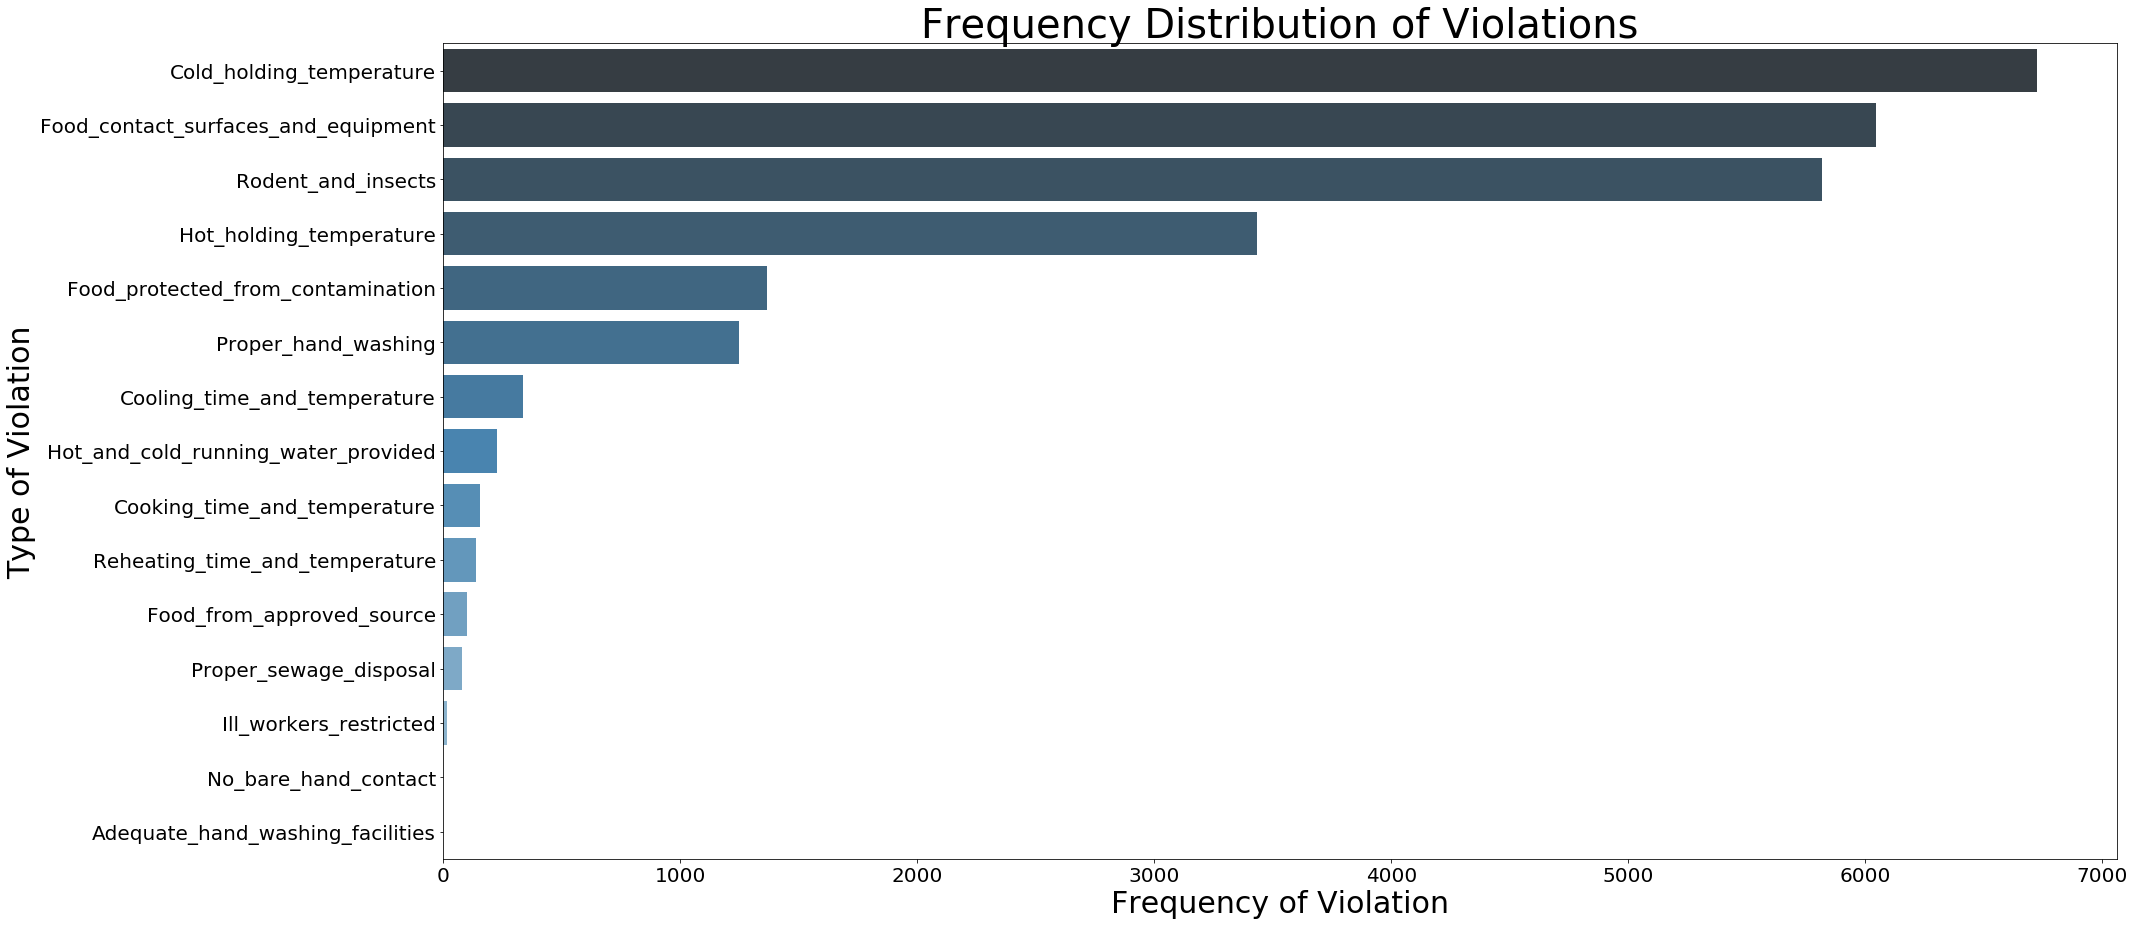

In [85]:
fig= plt.figure(figsize=(30,15))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# Create the bar plot 
ax = sns.barplot(x="Frequency", y="index", data=vdf, palette="Blues_d")
# Set a title
ax.set_title('Frequency Distribution of Violations', fontdict={'fontsize': 40})
# Set neat labels for x and y axis
plt.xlabel('Frequency of Violation', fontsize=30)
plt.ylabel('Type of Violation', fontsize=30)

### Violating restaurants across time..

<b>Question</b>: Create a line graph that shows the percent of restaurant inspections that have at least one violation by month and year. Are inspections getting harder or easier over time? Is there a particular month where more restaurants pass? Write 2-4 sentences with your observations.

In [86]:
# Creating a dataframe which only contains establishments which are restaurants
df1 = df[df['IsRestaurant'] == 1]

Text(0,0.5,'Percentage')

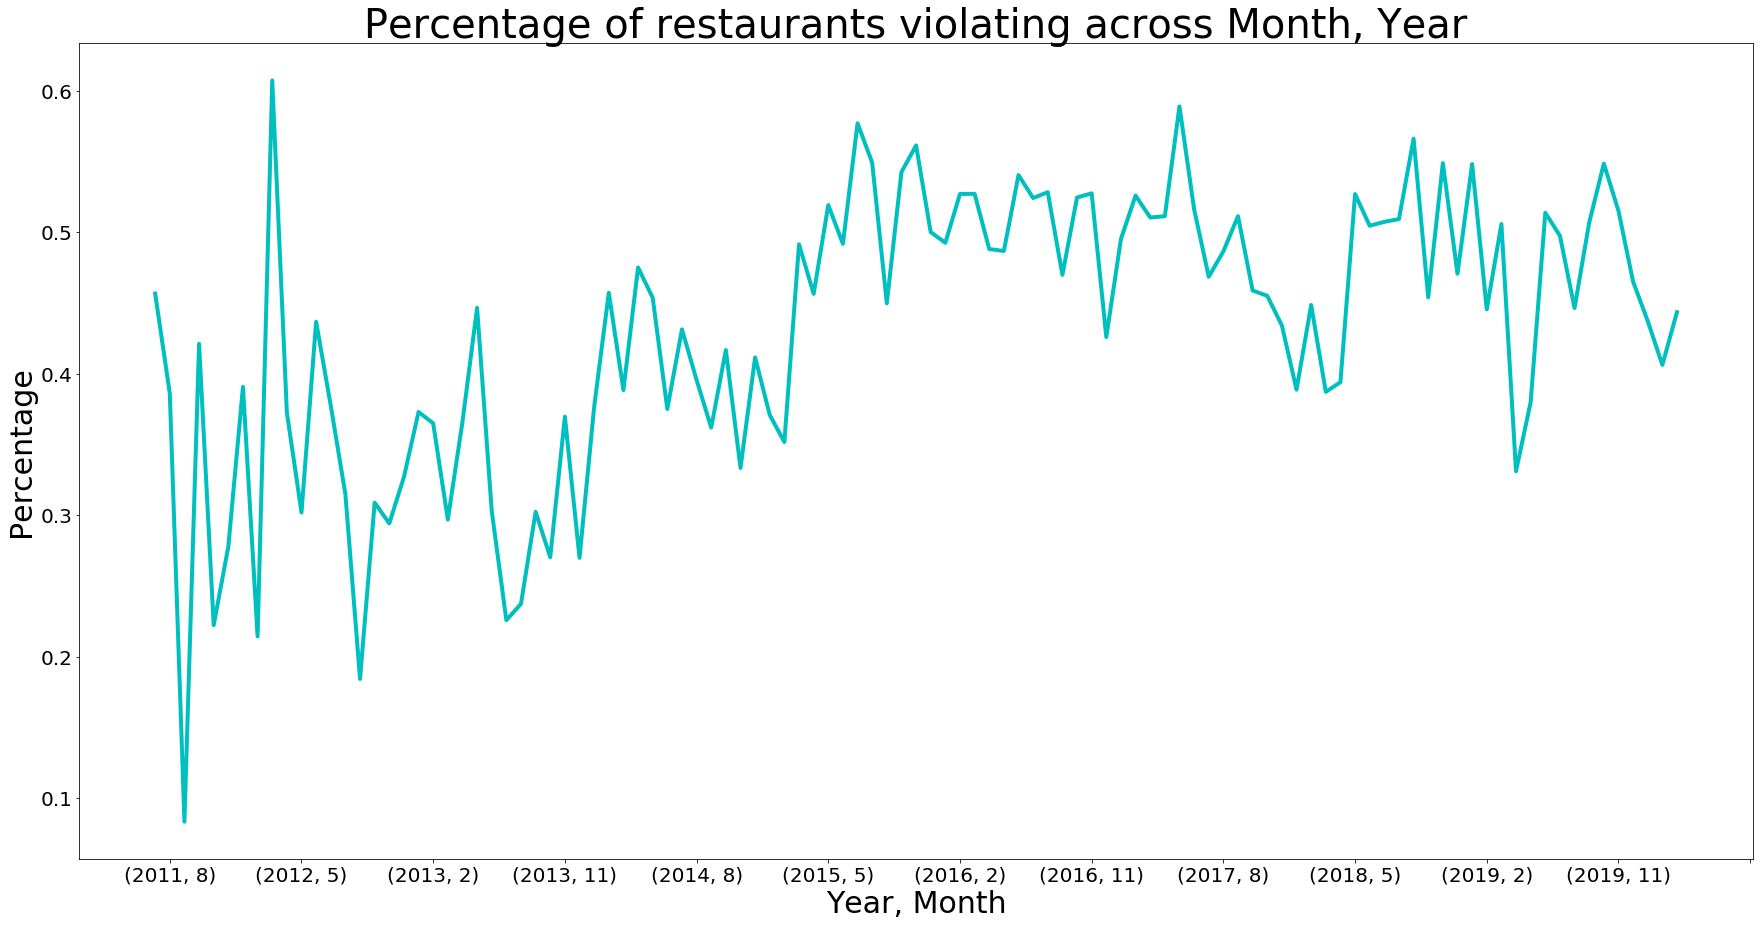

In [87]:
# Setting plot dimensions
fig= plt.figure(figsize=(30,15))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# The actual plot
ax = df1.groupby(['Inspection_year','Inspection_month'])['Out_of_Compliance'].agg('mean').plot(kind = 'line', color = 'c', linewidth = 4, xticks = np.arange(1, 115, 9))
ax.set_title('Percentage of restaurants violating across Month, Year', fontdict={'fontsize': 40})
# Setting the labels for x and y axis
plt.xlabel('Year, Month', fontsize=30)
plt.ylabel('Percentage', fontsize=30)

#### Observations

- There seems to be a seasonal pattern in the percentage of restaurants with compliance violations
- From the above plot, it looks like PG County sees a hike in the percentage of restaurants violating rules in the April-May-June period every year  
- The dip in percentage seems to be happening mostly in the Fall-Winter time, i.e., between September and December
- Over the years, there is however, a systematic increase in the percetage, which could be because of either or both of the following factors - a) Growth in the number of establishments over the years in county, and b) Increase in stringency of inspections

### On a map..

<b>Question</b>: Create a map that shows all of the restaurants. Color the restaurants with at least one violation in red. Are there particular areas with more violations? If there are clusters of violations, either through interactive visualization or by manually inspecting the data, look at the types of violations where there are clusters. Are there any trends? Write 2-4 sentences with your observations. If you did not use interactive visualization, explain how you explored trends in violation type by area. You may also create a second map showing violation types.

In [88]:
# A look at the location data in the df
df1[['Establishment_id', 'Location']].head(10)

,Establishment_id,Location
1,14622,NaN
6,1453,POINT (-76.822919 38.895049)
7,665,POINT (-76.898376 39.096737)
8,804,POINT (-76.892104 38.909337)
9,13553,NaN
16,44,POINT (-76.902885 38.931707)
18,2121,POINT (-77.01651 38.785187)
22,1149,POINT (-76.837675 39.095924)
25,8132,POINT (-76.949424 38.984745)
26,15274,POINT (-76.932045 38.944472)


In [89]:
df1['Location_Temp'] = df1['Location'].str.replace('POINT', '').str.replace('(', '').str.replace(')', '')
df1['Longitude'] = df1['Location_Temp'].str.split().str[0]
df1['Latitude'] = df1['Location_Temp'].str.split().str[1]

C:\Users\Sahitya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Sahitya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Sahitya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

In [90]:
mapbox_access_token = 'pk.eyJ1Ijoic2FoaWFuZ2FyYSIsImEiOiJjazlpMmkwZ28xNTJxM2VvMmpvNjhpcjR5In0.XvlhGNyUouT_ysVZU2Ir6A'

In [91]:
class_map_data = go.Scattermapbox(
        lon = df1['Longitude'],
        lat = df1['Latitude'],
        text = df1['Name'].str.title(),
        hoverinfo='text',
        mode = 'markers',
        marker = dict(
                    symbol = 'circle',
                    size = 10,
                    opacity = .5,
                    color = np.where(df['Out_of_Compliance'] == 0, 'green', 'red')
                )
)

class_map_layout = go.Layout(
        title = 'Restaurants with Violations on the Map',
        mapbox=go.layout.Mapbox(
            accesstoken=mapbox_access_token,
            zoom=1
        )
    )

class_map = go.Figure(data=class_map_data, layout=class_map_layout)
class_map.show()

From doing some zooming in and zooming out interactively on the map plot, these areas look like theere are more red dots (read restaurants with violations) -
- Annapolis Road
- Baltimore Ave
- Allentown Road
- Old Branch Ave

Let's inspect further to check if there are any trends in terms of types of violations for restaurants in these areas.

In [92]:
adf = pd.DataFrame(np.sum(df1[df1['Address_line_1'].str.contains("ANNAPOLIS RD")].iloc[:,10:25], axis=0), columns=['Annapolis_Road']).reset_index()
bdf = pd.DataFrame(np.sum(df1[df1['Address_line_1'].str.contains("BALTIMORE AVE")].iloc[:,10:25], axis=0), columns=['Baltimore_Ave']).reset_index()
aldf = pd.DataFrame(np.sum(df1[df1['Address_line_1'].str.contains("ALLENTOWN RD")].iloc[:,10:25], axis=0), columns=['Allentown_Road']).reset_index()
odf = pd.DataFrame(np.sum(df1[df1['Address_line_1'].str.contains("OLD BRANCH AVE")].iloc[:,10:25], axis=0), columns=['Old_Branch_Ave']).reset_index()

In [93]:
# Merge the dataframes
mdf = pd.concat([adf, bdf['Baltimore_Ave'], aldf['Allentown_Road'], odf['Old_Branch_Ave']], axis=1, sort=False)
mdf

,index,Annapolis_Road,Baltimore_Ave,Allentown_Road,Old_Branch_Ave
0,Food_from_approved_source,4.0,6.0,0.0,0.0
1,Food_protected_from_contamination,33.0,105.0,5.0,6.0
2,Ill_workers_restricted,0.0,2.0,0.0,0.0
3,Proper_hand_washing,37.0,109.0,8.0,6.0
4,Cooling_time_and_temperature,14.0,39.0,1.0,2.0
5,Cold_holding_temperature,183.0,446.0,36.0,39.0
6,Hot_holding_temperature,92.0,205.0,17.0,17.0
7,Cooking_time_and_temperature,6.0,12.0,1.0,1.0
8,Reheating_time_and_temperature,4.0,5.0,2.0,2.0
9,Hot_and_cold_running_water_provided,5.0,3.0,2.0,1.0


From the above data, it looks like the most common violations in the areas which seem to have more restaurants with violations are related to -
- Cold holding temperatures
- Rodents and insects
- Food contact surfaces and equipment
- Food protection from contamination

Restaurants in these areas could be suffering from these problems because of -
- Student population in and around College Park (Baltimore Ave)
- The type of restaurants - Fast food joints with less money and supervision can be relatively more unkempt than restaurants
- Rodent and insect infestations which can spread fast within an area
- Need to serve fast (which is becoming increasingly important in the food industry with the rising competition promising faster service/delivery) - leading to holding cold/frozen food 

## Conclusions

Our analysis has helped in finding some interesting insights about food inspections which can be helpful in enlightening consumers about the quality/safety of the food they consume at restaurants.

We have learned about the seasonality of violations in establishments in the PG County. Further, we dwelled further on which violations are more common than the others and found that holding cold food seems to be very common not to mention rodents and insects. 

Also, some areas are cleaner than others which can be due to the a variety of reasons ranging from the demographic of the area to the relative temperature and humidity. More research can be done on common violations among different categories of establishments.